In [50]:
import yaml
import umap

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor
from scipy.stats import mannwhitneyu

from cmonge.utils import get_source_target_transport, score_transports_and_targets_combinations, load_config
from cmonge.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from cmonge.datasets.conditional_loader import ConditionalDataModule

In [3]:
sns.set(font="Arial")
sns.set_context("paper")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [4]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "monge": default_colors["cyan"],
    "cmonge": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}


In [1]:
features = "/path/to/genesets/functional_and_score_genes.txt"

logger_path = "/path/to/model/logs/"
base_config_path = "/path/to/model/configs/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_ckpt_path =   "/path/to/model/checkpoint/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_fig_save =    "/path/to/figures/cmonge/ood/sel_CARs_"

data_path = "/path/to/data/"
car_embedding_path = "/path/to/car/embedding/"
variants_path = "/path/to/variants/"

In [6]:
all_mean_metrics=[]
for subset in ["CD4", "CD8"]:
    for setting in ["identity", "cmonge_ood", "within condition"]:
        with open(f"{logger_path}{subset}_{setting}_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                all_mean_metrics.append(res)

In [7]:
OOD_res = pd.concat(all_mean_metrics).reset_index(drop=True)
OOD_res = OOD_res[~OOD_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
OOD_res["eval_setting"] = ["cmonge" if "cmonge" in s else s for s in OOD_res["eval_setting"]]

In [52]:
pvals = []
metrics = []
subsets = []
comparisons = []
for metric in ["mean_mmd", "mean_r2"]:
    for subset in ["CD8", "CD4"]:
        for comparison in [("cmonge", "identity"), ("cmonge", "within condition")]:
            sel_res = OOD_res[(OOD_res["metric"]==metric)&(OOD_res["subset"]==subset)]
           
            pval = mannwhitneyu(sel_res.loc[sel_res["eval_setting"]==comparison[0], "score"], 
                                sel_res.loc[sel_res["eval_setting"]==comparison[1], 'score'],
                               ).pvalue 
            pvals.append(pval)
            metrics.append(metric)
            subsets.append(subset)
            comparisons.append(comparison)
stats = pd.DataFrame({"pval": pvals, "subset": subsets, "metric": metrics})
stats[["setting1", "setting2"]] = comparisons
stats["corr_pval"] = stats["pval"] *len(stats)
stats["treshold"] = 0.05/len(stats)
stats["significant1"] =  stats["pval"] < stats["treshold"]
stats["significant2"] =  stats["corr_pval"] < 0.05
stats

0.015922305616844122 0.00354785073550267
0.015922305616844122 0.009760598373649686
0.10609273071585282 0.12058023530710187
0.10609273071585282 0.0020680729426554635
0.7673864479189832 0.3759244915685505
0.7673864479189832 0.001814320828255746
0.35580542196526993 0.820055269942418
0.35580542196526993 0.0016733656665090108


/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)
/Users/adr/miniconda3/envs/cmonge/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  k, _ = kurtosistest(a, axis)


,pval,subset,metric,setting1,setting2,corr_pval,treshold,significant1,significant2
0,0.062097,CD8,mean_mmd,cmonge,identity,0.496777,0.00625,False,False
1,0.026364,CD8,mean_mmd,cmonge,within condition,0.210908,0.00625,False,False
2,0.323214,CD4,mean_mmd,cmonge,identity,2.585710,0.00625,False,False
3,0.012555,CD4,mean_mmd,cmonge,within condition,0.100438,0.00625,False,False
4,0.000002,CD8,mean_r2,cmonge,identity,0.000012,0.00625,True,True
5,0.002271,CD8,mean_r2,cmonge,within condition,0.018170,0.00625,True,True
6,0.000007,CD4,mean_r2,cmonge,identity,0.000060,0.00625,True,True
7,0.316763,CD4,mean_r2,cmonge,within condition,2.534106,0.00625,False,False


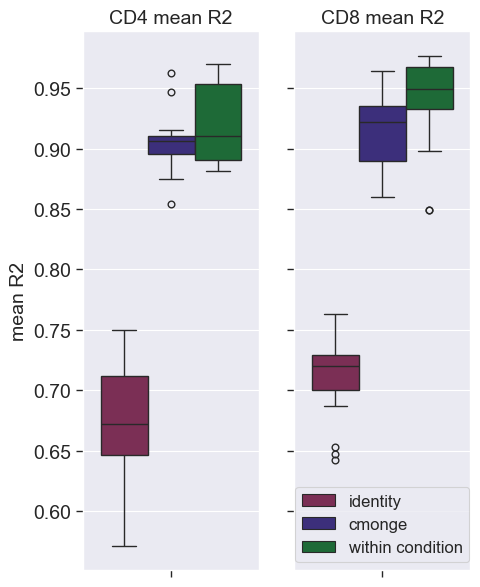

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_title(f"{subset} mean R2", fontsize=14)
    axes[i].set_ylabel("mean R2", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}R2_performance.pdf", bbox_inches="tight")

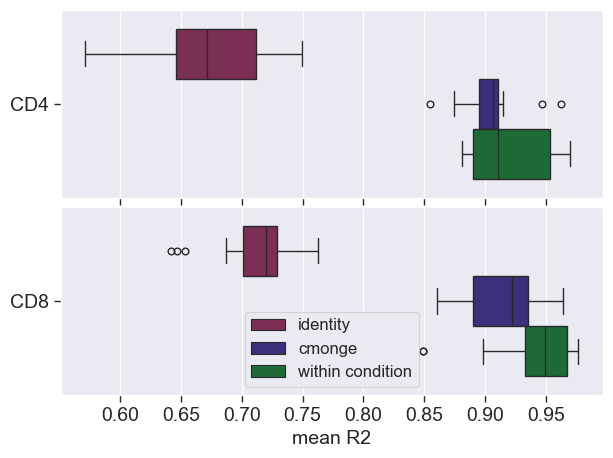

In [11]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_save}R2_performance_horizontal.pdf", bbox_inches="tight")

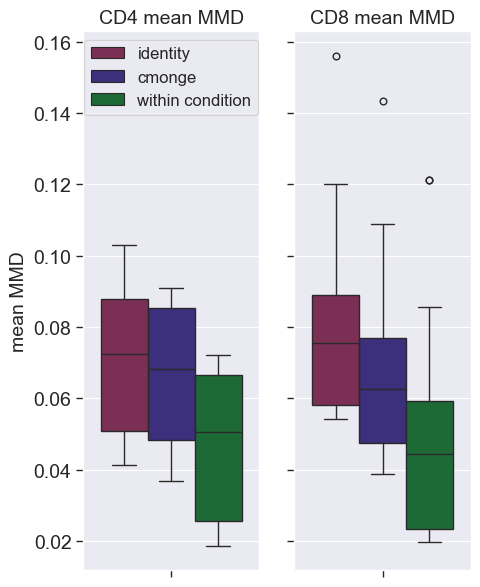

In [12]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}MMD_performance.pdf", bbox_inches="tight")

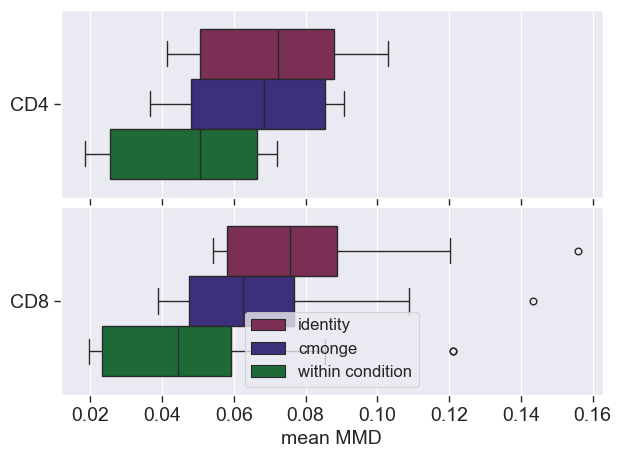

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = OOD_res[(OOD_res["subset"]==subset)&(OOD_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "cmonge", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_save}MMD_performance_horizontal.pdf", bbox_inches="tight")

## Compare ID and OOD CARs in different evaluation settings

In [ ]:
# setting="cmonge_ood"
setting="within condition"
# setting="identity"

for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f'{data_path}{subset}.h5ad')
    adata.X = adata.layers['logcounts']
    with open(features, "r") as f:
        genes = f.read().splitlines()
    sel_adata = adata[:, genes]

    config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
    config = load_config(config_path)
    config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
    config.data.file_path = f"{data_path}{subset}.h5ad"
    config.data.features = features
    config.data.drugs_path = f"{variants_path}{subset}_sel_cars.txt"
    config.model.embedding.model_dir = car_embedding_path

    with open(config.data.drugs_path) as f:
        train_cars = f.readlines()
    train_cars = [c[:-1] for c in train_cars]

    for car in sel_adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        if car in train_cars:
            continue
        config.condition.split = [0,1,0]
        config.data.split = [0,1,0]
        batch_size = min(sum(sel_adata.obs["CAR_Variant"]==car), sum(sel_adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1] / 9) # 9 in n_samples of the evaluation modules

        config.data.batch_size=batch_size
        config.condition.conditions = [car]

        if setting=="within condition":
            config.data.control_condition=car
        
        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=f"{logger_path}{subset}_{setting}_eval.yaml", 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )

        if setting=="identity" or setting=="within condition":
            trainer.evaluate(datamodule, identity=True)
        else:
            trainer.evaluate(datamodule)


2024-09-23 14:48:17.696 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:82 - Setting up datamodules for 41BB-CTLA4-z
2024-09-23 14:48:18.203 | INFO     | cmonge.datasets.single_loader:splitter:81 - Splitting dataset started.
2024-09-23 14:48:18.533 | INFO     | cmonge.datasets.single_loader:splitter:122 - Target dataset number of cells - train: (0,), valid: (311,), test: (0,).
2024-09-23 14:48:18.534 | INFO     | cmonge.datasets.single_loader:splitter:125 - Control dataset number of cells - train: (0,), valid: (311,), test: (0,).
2024-09-23 14:48:18.534 | INFO     | cmonge.datasets.single_loader:splitter:128 - Splitting finished.
2024-09-23 14:48:18.535 | INFO     | cmonge.trainers.ot_trainer:__init__:37 - JAX uses cpu for trianing.
2024-09-23 14:48:20.996 | INFO     | cmonge.trainers.conditional_monge_trainer:load_checkpoint:337 - Loaded ConditionalMongeTrainer from checkpoint
2024-09-23 14:48:20.997 | INFO     | cmonge.trainers.conditional_monge_trainer:evaluate:2

In [ ]:
all_mean_metrics=[]
for subset in ["CD4", "CD8"]:
    for setting in ["within condition"]:
        with open(f"{logger_path}{subset}_{setting}_ID_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                res["OOD_ID"] = ">750 cells"
                res["model"] = "sel_cars"
                all_mean_metrics.append(res)

        with open(f"{logger_path}model_all_cars_{subset}_{setting}_ID_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                res["OOD_ID"] = ">750 cells"
                res["model"] = "all_cars"
                all_mean_metrics.append(res)

        with open(f"{logger_path}model_all_cars_{subset}_{setting}_OOD_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                res["OOD_ID"] = "<750 cells"
                res["model"] = "all_cars"
                all_mean_metrics.append(res)

In [70]:
ID_res = pd.concat(all_mean_metrics).reset_index(drop=True)
ID_res = ID_res[~ID_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
ID_res["eval_setting"] = ["cmonge" if "cmonge" in s else s for s in ID_res["eval_setting"]]

In [71]:
temp = OOD_res[(OOD_res["eval_setting"]=="cmonge")]
temp["OOD_ID"] = "<750 cells"
temp["model"] = "sel_cars"
all_res = pd.concat([ID_res, temp])
ID_OOD_map = {"<750 cells": default_colors["rose"], ">750 cells": default_colors["green"]}

/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_15046/3524476035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["OOD_ID"] = "<750 cells"
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_15046/3524476035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["model"] = "sel_cars"


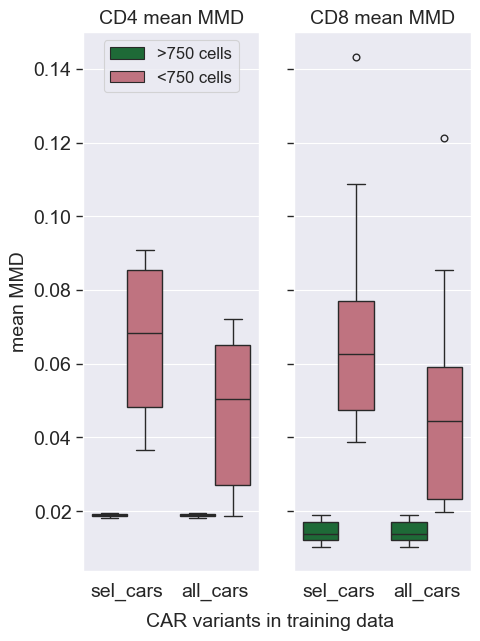

In [83]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = all_res[(all_res["subset"]==subset)&(all_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", ax=axes[i], hue="OOD_ID", x="model", palette=ID_OOD_map)
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
fig.text(0.25, 0.03, "CAR variants in training data", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}MMD_all_sel_CARs_OOD_ID_performance.pdf", bbox_inches="tight")

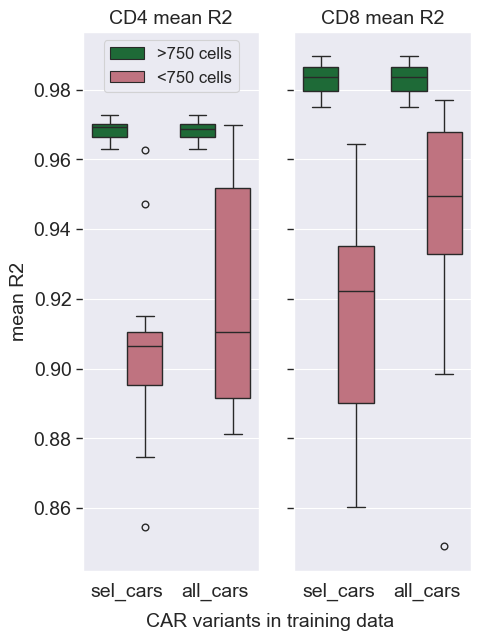

In [81]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = all_res[(all_res["subset"]==subset)&(all_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", ax=axes[i], hue="OOD_ID", x="model", palette=ID_OOD_map)
    axes[i].set_title(f"{subset} mean R2", fontsize=14)
    axes[i].set_ylabel("mean R2", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
fig.text(0.25, 0.03, "CAR variants in training data", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_save}R2_all_sel_CARs_OOD_ID_performance.pdf", bbox_inches="tight")